In [1]:
import json
import tqdm
import time
from operator import itemgetter
import random
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
import seaborn as sns
import numpy as np
import re
import joblib
import pandas as pd
from collections import defaultdict
from prettytable import PrettyTable
from wordcloud import WordCloud, STOPWORDS

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Dense, Conv1D, Dropout, Embedding, concatenate, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import text, image, sequence
from tensorflow.keras.applications.vgg19 import preprocess_input

from tensorflow_addons.metrics import F1Score

In [4]:
print('Using tf version: {}'.format(tf.__version__))
print('Using numpy version: {}'.format(np.__version__))

Using tf version: 2.5.0
Using numpy version: 1.19.2


In [58]:
# folder of data
DATA_FOLDER = '../content'
# folder of processed data
PROCESSED_DATA_FOLDER = '../content/processed_data'
# folder of dataset evaluation
EVALUATION_DATA_FOLDER = '../content/evaluation'
# path image format
IMAGE_FORMAT = '../content/%s/COCO_%s_%012d.jpg'

# Preparing the data matrices

In [6]:
# loading from disk
# Reduced train dataset to contain only the datapoints whose answer occurence is in top most frequents
with open(f'{PROCESSED_DATA_FOLDER}/vqa_raw_train2014_top1000.json', 'rb') as f:
    clQuestionTrain, clAnswerTrain, clAnswersTrain, clPathImageTrain = joblib.load(f)

# Reduced validation dataset to contain only the datapoints whose answer occurence is in top most frequents
with open(f'{PROCESSED_DATA_FOLDER}/vqa_raw_val2014_top1000.json', 'rb') as f:
    clQuestionVal, clAnswerVal, clAnswersVal, clPathImageVal = joblib.load(f)

In [7]:
# load from disk : question tokenization class
with open(f'{DATA_FOLDER}/text_tokenizer.pkl', 'rb') as f:
    oTok = joblib.load(f)

In [8]:
# load from disk : Tokenized questions
with open(f'{DATA_FOLDER}/tokenised_question_paddingPost.pkl', mode='rb') as f:
    caQuestionTrainTokenized, caQuestionValTokenized = joblib.load(f)

In [9]:
# load from disk: Encode target answers with value between 0 and n_classes-1
with open(f'{DATA_FOLDER}/labelEncoder.pkl', 'rb') as f:
    oLabelEncoder = joblib.load(f)

C:\Users\vbui\anaconda3\envs\VQA\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
"""
    Function name: GetAnswersMatrix
    
    Objective: One-hot-encode the answers
    
    Summary algorithmic description: Transform answers to normalized encoding.
                                     Convert the normalized encoding to one-hot-coding
    
    Input parameters: clAnswer : list of answers
                      cEncoder : LabelEncoder class
    
    Return : binary class matrix
    
    Date : 09/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def GetAnswersMatrix(clAnswer, cEncoder):
    # Transform labels to normalized encoding.
    y = cEncoder.transform(clAnswer) 
    # Number of classes 
    iNbClasses = cEncoder.classes_.shape[0]
    # Convert a class vector (integers) to binary class matrix.
    Y = utils.to_categorical(y, iNbClasses)
    # Return the binary class matrix.
    return Y

In [11]:
# Stratified ShuffleSplit cross-validator
cStratifiedShuffleSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
# Generate indices to split data into training and test set
for caTrainIndex, caValIndex in cStratifiedShuffleSplit.split(clPathImageTrain, clAnswerTrain):
    TRAIN_INDEX = caTrainIndex
    VAL_INDEX = caValIndex

In [12]:
# trainning image data
caPathImageToTrain = np.array(clPathImageTrain)[TRAIN_INDEX.astype(int)] 
# validation image data
caPathImageToVal = np.array(clPathImageTrain)[VAL_INDEX.astype(int)]

# training question data
caQuestionTokenToTrain = caQuestionTrainTokenized[TRAIN_INDEX]
# validation image 
caQuestionTokenToVal = caQuestionTrainTokenized[VAL_INDEX]

In [13]:
caQuestionTokenToTrain

array([[  8,  10, 107, ...,   0,   0,   0],
       [  3,  12,   2, ...,   0,   0,   0],
       [  2,   5,   7, ...,   0,   0,   0],
       ...,
       [  2,  86,  19, ...,   0,   0,   0],
       [  3,  27,  11, ...,   0,   0,   0],
       [  3, 115,   2, ...,   0,   0,   0]])

In [14]:
# One-hot-encode the train answers 
caAnswerMatrix = GetAnswersMatrix(clAnswerTrain, oLabelEncoder)
# One-hot-coding Matrix for trainning and validation
caAnswerMatrixToTrain, caAnswerMatrixToVal = caAnswerMatrix[TRAIN_INDEX], caAnswerMatrix[VAL_INDEX]

In [15]:
caAnswerMatrix.shape

(388158, 1000)

In [16]:
caAnswerMatrixToTrain

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Model

In [17]:
"""
    Class name: AttentionMaps 
    
    Objective: Compute the image (or question) attention
    
    Summary algorithmic description: Calculate the affinity matrix
                                     Predict image and question attention maps
    
    Input parameters: iDim_k : hidden attention dimention
                      fRegValue : Regularization value
    
    Date : 14/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
class AttentionMaps(tf.keras.layers.Layer):
    """
        Function name: __init__

        Objective: Define custom layer attributes

        Summary algorithmic description: Define two attributes hidden attention dimention and regularization value
                                         Define the weight parameters by layer Dense

        Input parameters: iDim_k : hidden attention dimention
                          fRegValue : Regularization value

        Return : None

        Date : 14/11/2021

        Coding: INSA CVL - Van Tuan BUI  
    """
    def __init__(self, iDim_k, fRegValue, **kwargs):
        # Default layer attributes
        super(AttentionMaps, self).__init__(**kwargs)

        # Get the value of hidden attention dimention
        self.iDim_k = iDim_k
        # Get the regularization value 
        self.fRegValue = fRegValue

        # Dense layer with Xavier uniform initializer for image weight parameters 
        self.Wv = Dense(self.iDim_k, activation=None,\
                        kernel_regularizer=tf.keras.regularizers.l2(self.fRegValue),\
                        kernel_initializer=tf.keras.initializers.glorot_uniform(seed=2))
        # Dense layer with Xavier uniform initializer for question weight parameters
        self.Wq = Dense(self.iDim_k, activation=None,\
                        kernel_regularizer=tf.keras.regularizers.l2(self.fRegValue),\
                        kernel_initializer=tf.keras.initializers.glorot_uniform(seed=3))
        
        
    """
        Function name: call

        Objective: Perform the logic of applying the layer to the input tensors

        Summary algorithmic description: Calculate the affinity matrix
                                         Predict image and question attention maps

        Input parameters: caImageFeat : image feature (b, N,  d) 
                          caQuestionFeat : question feature (b, T,  d)

        Return : image attention map and question attention map

        Date : 14/11/2021

        Coding: INSA CVL - Van Tuan BUI  
    """
    def call(self, caImageFeat, caQuestionFeat):
        # Affinity Matrix C = tanh((QT)(Wb)V) (b, T, N)
        C = tf.matmul(caQuestionFeat, tf.transpose(caImageFeat, perm=[0,2,1])) 
        C = tf.keras.activations.tanh(C) 

        # (Wv)V (b, N, k)
        Wv_V = self.Wv(caImageFeat)                             
        # (Wq)Q (b, T, k)
        Wq_Q = self.Wq(caQuestionFeat)                              

        # ((Wq)Q)C (b, k, N)
        Wq_Q_C = tf.matmul(tf.transpose(Wq_Q, perm=[0,2,1]), C) 
        # ((Wq)Q)C (b, N, k)
        Wq_Q_C = tf.transpose(Wq_Q_C, perm =[0,2,1])       

        # ((Wv)V)CT (b, k, T)                                         
        Wv_V_CT = tf.matmul(tf.transpose(Wv_V, perm=[0,2,1]), tf.transpose(C, perm=[0,2,1])) 
        # ((Wv)V)CT (b, T, k) 
        Wv_V_CT = tf.transpose(Wv_V_CT, perm =[0,2,1])         

        # image attention map Hv = tanh((Wv)V + ((Wq)Q)C) (b, N, k)
        Hv = Wv_V + Wq_Q_C                                     
        Hv = tf.keras.activations.tanh(Hv)              

        # question attention map Hq = tanh((Wq)Q + ((Wv)V)CT) (b, T, k)
        Hq = Wq_Q + Wv_V_CT                                     
        Hq = tf.keras.activations.tanh(Hq)                   

        # Return image attention map and question attention map
        return [Hv, Hq]                                     
  

    """
        Function name: get_config

        Objective: Collect the input shape and other information about the layer.

        Summary algorithmic description: Return a dictionary containing the configuration used to initialize this layer

        Input parameters: None

        Return : a dictionary containing informations about the layer.

        Date : 14/11/2021

        Coding: INSA CVL - Van Tuan BUI  
    """
    def get_config(self):
        # Dictionnary of two attributes of this layer
        cdConfig = {
            'iDim_k': self.iDim_k,
            'fRegValue': self.fRegValue
        }
        # Dictionnary of base configurations
        cdBasaConfig = super(AttentionMaps, self).get_config()
        # Return a dictionary containing informations about the layer.
        return dict(list(cdBasaConfig.items()) + list(cdConfig.items()))

In [18]:
cLayerAttentionMaps = AttentionMaps(64, 0.001)
cdConfig = cLayerAttentionMaps.get_config()
print(cdConfig)
cNewLayerAttentionMaps = AttentionMaps.from_config(cdConfig)

{'name': 'attention_maps', 'trainable': True, 'dtype': 'float32', 'iDim_k': 64, 'fRegValue': 0.001}


In [19]:
"""
    Class name: ContextVector 
    
    Objective: Find context vector of the image and text features
    
    Summary algorithmic description: 
    
    Input parameters: iDim_k : hidden attention dimention
                      fRegValue : Regularization value
    
    Date : 14/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
class ContextVector(tf.keras.layers.Layer):
    """
        Function name: __init__

        Objective: Define custom layer attributes

        Summary algorithmic description: Define attribute regularization value
                                         Define the weight parameters by layer Dense

        Input parameters: fRegValue : Regularization value

        Return : None

        Date : 14/11/2021

        Coding: INSA CVL - Van Tuan BUI  
    """
    def __init__(self, fRegValue, **kwargs):
        # Default layer attributes
        super(ContextVector, self).__init__(**kwargs)

        # Get the regularization value 
        self.fRegValue = fRegValue
        # Image weight parameters (Dense layer with Xavier uniform initializer)
        self.whv = Dense(1, activation='softmax',\
                            kernel_regularizer=tf.keras.regularizers.l2(self.fRegValue),\
                            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=4))
        # Image weight parameters (Dense layer with Xavier uniform initializer)
        self.whq = Dense(1, activation='softmax',\
                            kernel_regularizer=tf.keras.regularizers.l2(self.fRegValue),\
                            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=5)) 
    

    """
        Function name: call

        Objective: Perform the logic of applying the layer to the input tensors

        Summary algorithmic description: Find context vector of the image and text features

        Input parameters: caImageFeat : image feature (b, N,  d) 
                          caQuestionFeat : question feature (b, T,  d)
                          Hv : image attention map (b, N, k)
                          Hq : question attention map (b, T, k)

        Return : context vector of the image and text features

        Date : 14/11/2021

        Coding: INSA CVL - Van Tuan BUI  
    """
    def call(self, caImageFeat, caQuestionFeat, Hv, Hq):
        # attention probabilities of each image region vn
        # av = softmax(wT_hv * H_v) (b, N, 1)
        av = self.whv(Hv)                               

        # attention probabilities of each word qt      
        # aq = softmax(wT_hq * H_q) (b, T, 1)
        aq = self.whq(Hq)                              

        # context vector for image (b, N, d)
        v = av * caImageFeat 
        # context vector for image (b, d)
        v = tf.reduce_sum(v, 1)                            

        # context vector for question (b, T, d)
        q = aq * caQuestionFeat                               
        # context vector for question (b, d)
        q = tf.reduce_sum(q, 1)            
        
        # Return context vector of the image and text features
        return [v, q]

    
    """
        Function name: get_config

        Objective: Collect the input shape and other information about the layer.

        Summary algorithmic description: Return a dictionary containing the configuration used to initialize this layer

        Input parameters: None

        Return : a dictionary containing informations about the layer.

        Date : 14/11/2021

        Coding: INSA CVL - Van Tuan BUI  
    """
    def get_config(self):
        # Dictionnary of attributes of this layer
        cdConfig = {
            'fRegValue': self.fRegValue
        }
        # Dictionnary of base configurations
        cdBaseConfig = super(ContextVector, self).get_config()
        # Return a dictionary containing informations about the layer
        return dict(list(cdBaseConfig.items()) + list(cdConfig.items()))

In [20]:
cLayerContextVector = ContextVector(0.001)
cdConfig = cLayerContextVector.get_config()
print(cdConfig)
cNewLayerContextVector = ContextVector.from_config(cdConfig)

{'name': 'context_vector', 'trainable': True, 'dtype': 'float32', 'fRegValue': 0.001}


In [21]:
"""
    Class name: PhraseLevelFeatures 
    
    Objective: Compute the phrase features by applying 1-D convolution on the word embedding vectors
    
    Summary algorithmic description: Applying 1-D convolution with filters of three window sizes: unigram, bigram and trigram
                                     Max-pooling across different n-grams at each word location
    
    Input parameters: iDim_d : hidden dimension
    
    Date : 14/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
class PhraseLevelFeatures(tf.keras.layers.Layer):
    """
        Function name: __init__

        Objective: Define custom layer attributes

        Summary algorithmic description: Define attribute hidden dimension
                                         Define the weight parameters by 1D convolution layer

        Input parameters: iDim_d : hidden dimension

        Return : None

        Date : 14/11/2021

        Coding: INSA CVL - Van Tuan BUI  
    """
    def __init__(self, iDim_d, **kwargs):
        # Default layer attributes
        super(PhraseLevelFeatures, self).__init__(**kwargs)

        # Get the hidden dimension
        self.iDim_d = iDim_d
        # Convolution with filter unigram
        self.conv_unigram = Conv1D(self.iDim_d, kernel_size=1, strides=1,\
                                    kernel_initializer=tf.keras.initializers.glorot_uniform(seed=6)) 
        # Convolution with filter bigram
        self.conv_bigram =  Conv1D(self.iDim_d, kernel_size=2, strides=1, padding='same',\
                                    kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7)) 
        # Convolution with filter trigram
        self.conv_trigram = Conv1D(self.iDim_d, kernel_size=3, strides=1, padding='same',\
                                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=8)) 

        
    """
        Function name: call

        Objective: Perform the logic of applying the layer to the input tensors

        Summary algorithmic description: Compute the n-gram phrase embeddings (n = 1,2,3)

        Input parameters: caWordFeat : word feature (b, T, d) 

        Return : Phrase level features of the question (b, T, d)

        Date : 14/11/2021

        Coding: INSA CVL - Van Tuan BUI  
    """
    def call(self, caWordFeat):
        # phrase level unigram features (b, T, d)
        qpUnigram = self.conv_unigram(caWordFeat)                    

        # phrase level bigram features (b, T, d)
        qpBigram  = self.conv_bigram(caWordFeat)                     

        # phrase level trigram features (b, T, d)
        qpTrigram = self.conv_trigram(caWordFeat)             

        # phrase level features (b, T, d, 3)
        qp = tf.concat([tf.expand_dims(qpUnigram, -1),\
                        tf.expand_dims(qpBigram, -1),\
                        tf.expand_dims(qpTrigram, -1)], -1)         

        # Max-pool across n-gram features, over-all phrase level feature (b, T, d)
        qp = tf.reduce_max(qp, -1)                                

        # Return phrase level features
        return qp

    """
        Function name: get_config

        Objective: Collect the input shape and other information about the layer.

        Summary algorithmic description: Return a dictionary containing the configuration used to initialize this layer

        Input parameters: None

        Return : a dictionary containing informations about the layer.

        Date : 14/11/2021

        Coding: INSA CVL - Van Tuan BUI  
    """
    def get_config(self):
        # Dictionnary of attributes of this layer
        cdConfig = {
            'iDim_d': self.iDim_d
        }
        # Dictionnary of base configurations
        cdBaseConfig = super(PhraseLevelFeatures, self).get_config()
        # Return a dictionary containing informations about the layer
        return dict(list(cdBaseConfig.items()) + list(cdConfig.items()))

In [22]:
cLayerPhraseLevelFeatures = PhraseLevelFeatures(32)
cdConfig = cLayerPhraseLevelFeatures.get_config()
print(cdConfig)
cNewLayerPhraseLevelFeatures = PhraseLevelFeatures.from_config(cdConfig)

{'name': 'phrase_level_features', 'trainable': True, 'dtype': 'float32', 'iDim_d': 32}


# Architecture

In [23]:
N = 49
T = 22

In [24]:
"""
    Function name: BuildModel

    Objective: build the training model

    Summary algorithmic description: Calculate co-attended image and question features from all three levels
                                     Use a multi-layer perceptron (MLP) to recursively encode the attention features
    
    Input parameters: iMaxAnswers : Number of output targets of the model
                      iMaxSequenceLength : Maximum length of input sequences
                      iVocabSize : Size of the vocabulary
                      iDim_d : Hidden dimension
                      iDim_k : Hidden attention dimension
                      fLearningRate : Learning rate for the model
                      fDropoutRate : Dropout rate
                      fRegValue : Regularization value

    Return : The training model

    Date : 14/11/2021

    Coding: INSA CVL - Van Tuan BUI  
"""
def BuildModel(iMaxAnswers, iMaxSequenceLength, iVocabSize, iDim_d, iDim_k, fLearningRate, fDropoutRate, fRegValue):
    # inputs 
    caImageInput = Input(shape=(49, 512, ), name='Image_Input')
    caQuestionInput = Input(shape=(22, ), name='Question_Input')

    # image feature (Wb)V (b, N, d)
    caImageFeature = Dense(iDim_d, activation=None, name='Image_Feat_Dense',\
                        kernel_regularizer=tf.keras.regularizers.l2(fRegValue),\
                        kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1))(caImageInput)
    # image feature (b, N, d)
    caImageFeature = Dropout(fDropoutRate, seed=1)(caImageFeature)

    # word embedding feature
    caWordFeature = Embedding(input_dim=iVocabSize, output_dim=iDim_d, input_length=iMaxSequenceLength,\
                            mask_zero=True)(caQuestionInput)
    # image and question attention maps at word level
    Hvw, Hqw = AttentionMaps(iDim_k, fRegValue, name='AttentionMaps_Word')(caImageFeature, caWordFeature)
    # context vector of the image and text features at word level
    vw, qw = ContextVector(fRegValue, name='ContextVector_Word')(caImageFeature, caWordFeature, Hvw, Hqw)
    # attention features at word level
    caWordAttentionFeature = tf.add(vw, qw)
    # co-attended image and question features from word level
    hw = Dense(iDim_d, activation='tanh', name='hw_Dense',\
                kernel_regularizer=tf.keras.regularizers.l2(fRegValue),\
                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=13))(caWordAttentionFeature)

    # phrase level features
    caPhraseFeature = PhraseLevelFeatures(iDim_d, name='PhraseLevelFeatures')(caWordFeature)
    # image and question attention maps at phrase level
    Hvp, Hqp = AttentionMaps(iDim_k, fRegValue, name='AttentionMaps_Phrase')(caImageFeature, caPhraseFeature)
    # context vector of the image and text features at phrase level
    vp, qp = ContextVector(fRegValue, name='ContextVector_Phrase')(caImageFeature, caPhraseFeature, Hvp, Hqp)
    # attention features at phrase level
    caPhraseAttentionFeature = concatenate([tf.add(vp, qp), hw], -1) 
    # co-attended image and question features from phrase level
    hp = Dense(iDim_d, activation='tanh', name='hp_Dense',\
                kernel_regularizer=tf.keras.regularizers.l2(fRegValue),\
                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=14))(caPhraseAttentionFeature)

    # sentence level
    caSentenceFeature = LSTM(iDim_d, return_sequences=True, input_shape=(None, iMaxSequenceLength, iDim_d),\
                            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=16))(caPhraseFeature)
    # image and question attention maps at sentence level
    Hvs, Hqs = AttentionMaps(iDim_k, fRegValue, name='AttentionMaps_Sent')(caImageFeature, caSentenceFeature)
    # context vector of the image and text features at sentence level
    vs, qs = ContextVector(fRegValue, name='ContextVector_Sent')(caImageFeature, caSentenceFeature, Hvs, Hqs)
    # attention features at sentence level
    caSentenceAttentionFeature = concatenate([tf.add(vs, qs), hp], -1) 
    # co-attended image and question features from sentence level
    hs = Dense(2 * iDim_d, activation='tanh', name='hs_Dense',\
                kernel_regularizer=tf.keras.regularizers.l2(fRegValue),\
                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=15))(caSentenceAttentionFeature)

    # encode the attention features
    z = Dense(2 * iDim_d, activation='tanh', name='z_Dense',\
                kernel_regularizer=tf.keras.regularizers.l2(fRegValue),\
                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=16))(hs)
    # encode the attention features
    z = Dropout(fDropoutRate, seed=16)(z)

    # probability of the final answer
    result = Dense(iMaxAnswers, activation='softmax')(z)
    
    # group layers
    model = Model(inputs=[caImageInput, caQuestionInput], outputs=result)

    # Return the model
    return model

# Create tf.Dataset

In [25]:
# batch size
BATCH_SIZE = 300
# buffer siez
BUFFER_SIZE = 5000

In [26]:
"""
    Function name: GetImageFeatures

    Objective: Load the image features from numpy files

    Summary algorithmic description: Load the image features from numpy files

    Input parameters: sPathImage : path image
                      caQuestion : Tokenization of question
                      caAnswer : answer one-hot-enconding 

    Return : caImageTensor : image features
             caQuestion : Tokenization of question
             caAnswer : answer one-hot-enconding 

    Date : 15/11/2021

    Coding: INSA CVL - Van Tuan BUI  
"""
def GetImageFeatures(sPathImage, caQuestion, caAnswer):
    # Load the image features from numpy files
    caImageTensor = np.load(f'{DATA_FOLDER}/features/' + sPathImage.decode('utf-8').split('.')[2][-6:] + '.npy')
    # Return image features, tokenization of question and answer one-hot-enconding 
    return caImageTensor, caQuestion, caAnswer

In [27]:
# Create a Dataset whose elements are slices along their first dimension
oTrainDataset = tf.data.Dataset.from_tensor_slices((caPathImageToTrain, caQuestionTokenToTrain, caAnswerMatrixToTrain))

# Use map to load the numpy files in parallel
oTrainDataset = oTrainDataset.map(lambda sPathImage, caQuestion, caAnswer: tf.numpy_function(
    GetImageFeatures, [sPathImage, caQuestion, caAnswer], [tf.float32, tf.int32, tf.float32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
oTrainDataset = oTrainDataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# allow later elements to be prepared while the current element is being processed.
oTrainDataset = oTrainDataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [28]:
# Create a Dataset whose elements are slices along their first dimension
oValDataset = tf.data.Dataset.from_tensor_slices((caPathImageToVal, caQuestionTokenToVal, caAnswerMatrixToVal))

# Use map to load the numpy files in parallel
oValDataset = oValDataset.map(lambda sPathImage, caQuestion, caAnswer: tf.numpy_function(
    GetImageFeatures, [sPathImage, caQuestion, caAnswer], [tf.float32, tf.int32, tf.float32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
oValDataset = oValDataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# allow later elements to be prepared while the current element is being processed.
oValDataset = oValDataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Training

In [29]:
# params 1
MAX_ANSWERS = 1000
MAX_SEQUENCE_LENGTH = 22
VOCAB_SIZE = len(oTok.word_index) + 1
EPOCHS      = 60
DIM_D = 512
DIM_K = 256
LEARNING_RATE = 1e-4
DROPOUT_RATE = 0.5
REG_VALUE = 0.01

BASE_PATH = f'{DATA_FOLDER}/temps'

In [30]:
# create model
oModel = BuildModel(MAX_ANSWERS, MAX_SEQUENCE_LENGTH, VOCAB_SIZE, DIM_D, DIM_K, LEARNING_RATE, DROPOUT_RATE, REG_VALUE)

In [31]:
oModel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 49, 512)]    0                                            
__________________________________________________________________________________________________
Image_Feat_Dense (Dense)        (None, 49, 512)      262656      Image_Input[0][0]                
__________________________________________________________________________________________________
Question_Input (InputLayer)     [(None, 22)]         0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 49, 512)      0           Image_Feat_Dense[0][0]           
______________________________________________________________________________________________

In [32]:
# number of steps per epoch
iStepsPerEpoch = int(np.ceil(len(caPathImageToTrain)/BATCH_SIZE))
# interval boundaries for changed learning rates.
clBoundary = [50 * iStepsPerEpoch]
# the learning rate values for the intervals defined by boundaries.
clLearningRateValue = [LEARNING_RATE, LEARNING_RATE / 10]

In [33]:
# we reduce the learning rate after 50th epoch (from 1e-4 to 1e-5)
learningRateSchedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(clBoundary, clLearningRateValue)
# Optimizer that implements the Adam algorithm
oOptimizer = tf.keras.optimizers.Adam(learning_rate=learningRateSchedule)
# the crossentropy loss between the labels and predictions
oLoss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='auto')

In [34]:
# checkpoint directory
sCheckpointDirectory = BASE_PATH + "/training_checkpoints/" + str(LEARNING_RATE) + "_" + str(DIM_K)
# save checkpoint every SAVE_CKPT_FREQ step
SAVE_CKPT_FREQ = 5

In [35]:
# Create a Checkpoint that will manage three objects with trackable state
oCheckpoint = tf.train.Checkpoint(step=tf.Variable(0), optimizer=oOptimizer, model=oModel)
# keep only 3 newest checkpoints 
oCheckPointManager = tf.train.CheckpointManager(oCheckpoint, sCheckpointDirectory, max_to_keep=3)

In [36]:
# Compute the (weighted) mean of the given values
oTrainLoss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
# Compute the (weighted) mean of the given values
oValLoss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)

In [37]:
# Compute F-1 Score
oTrainScore = F1Score(num_classes=MAX_ANSWERS, average='micro', name='train_score')
# Compute F-1 Score
oValScore = F1Score(num_classes=MAX_ANSWERS, average='micro', name='val_score')

In [38]:
# training log directory
sTrainLogDir = BASE_PATH + '/logs/' + str(LEARNING_RATE) + "_" + str(DIM_K) + '/train'
# validation log directory
sValLogDir   = BASE_PATH + '/logs/' + str(LEARNING_RATE) + "_" + str(DIM_K) + '/validation'

# Create a summary file writer for the training log directory
oTrainSummaryWriter = tf.summary.create_file_writer(sTrainLogDir)
# Create a summary file writer for the validation log directory
oValSummaryWriter = tf.summary.create_file_writer(sValLogDir)

In [39]:
"""
    Function name: TrainStep

    Objective: Operate a traning step

    Summary algorithmic description: Make a forward pass
                                     Make a backward pass
                                     Record results : loss mean, F1 score

    Input parameters: oModel : training model
                      tsImageFeature : image feature tensor
                      tsQuestionFeature : question feature tensor
                      tsAnswerLabel : answer label tensor
                      oOptimizer : Optimizer object

    Return : clGradient_ : all gradients against trainable variables

    Date : 15/11/2021

    Coding: INSA CVL - Van Tuan BUI  
"""
def TrainStep(oModel, tsImageFeature, tsQuestionFeature, tsAnswerLabel, oOptimizer):
    # Record operations for automatic differentiation
    with tf.GradientTape() as oGradientTape:
        # forward pass
        # résultat de la prédiction
        tsPrediction = oModel([tsImageFeature, tsQuestionFeature], training=True)
        # the crossentropy loss
        fLoss = oLoss(tsAnswerLabel, tsPrediction)

    # backward pass
    # Compute the gradient of the loss
    clGradient = oGradientTape.gradient(fLoss, oModel.trainable_variables)
    # Apply gradients to variables
    oOptimizer.apply_gradients(zip(clGradient, oModel.trainable_variables))

    # record results
    # Loss Mean
    oTrainLoss(fLoss)
    # F-1 Score
    oTrainScore(tsAnswerLabel, tsPrediction)

    # all gradients
    clGradient_ = list(zip(clGradient, oModel.trainable_variables))
    # Return all gradients
    return clGradient_

In [40]:
"""
    Function name: TestStep

    Objective: Operate a testing step

    Summary algorithmic description: Make a prediction
                                     Record results : loss mean, F1 score

    Input parameters: oModel : training model
                      tsImageFeature : image feature tensor
                      tsQuestionFeature : question feature tensor
                      tsAnswerLabel : answer label tensor

    Return : None

    Date : 15/11/2021

    Coding: INSA CVL - Van Tuan BUI  
"""
def TestStep(oModel, tsImageFeature, tsQuestionFeature, tsAnswerLabel):
    # résultat de la prédiction
    tsPrediction = oModel([tsImageFeature, tsQuestionFeature])
    # the crossentropy loss
    fLoss = oLoss(tsAnswerLabel, tsPrediction)

    # record results
    # Loss Mean
    oValLoss(fLoss)
    # F-1 Score
    oValScore(tsAnswerLabel, tsPrediction)

In [41]:
# If the prefix of the most recent checkpoint exist
if oCheckPointManager.latest_checkpoint:
    # Restore the latest checkpoint
    oCheckpoint.restore(oCheckPointManager.latest_checkpoint)
    # Display the prefix of the most recent checkpoint
    print("Restored from {}".format(oCheckPointManager.latest_checkpoint))
    # latest training epoch
    START_EPOCH = int(oCheckPointManager.latest_checkpoint.split('-')[-1]) * SAVE_CKPT_FREQ
    print("Resume training from epoch: {}".format(START_EPOCH))
# If the prefix of the most recent checkpoint doesn't exist
else:
    print("Initializing from scratch")
    # Train from scratch
    START_EPOCH = 0

Restored from ../content/temps/training_checkpoints/0.0001_256\ckpt-12
Resume training from epoch: 60


In [42]:
# Loop over all epochs
for iEpoch in range(START_EPOCH, EPOCHS):
    # time in seconds since the epoch as a floating point number
    fStartTime = time.time()

    # Loop over all elements in training dataset
    for tsImageFeature, tsQuestionFeature, tsAnswerLabel in (oTrainDataset):
        # Make a training step
        clGradient = TrainStep(oModel, tsImageFeature, tsQuestionFeature, tsAnswerLabel, oOptimizer)

    # tensorboard 
    # set default writer
    with oTrainSummaryWriter.as_default():
        # Write the crossentropy loss for later analysis in TensorBoard
        tf.summary.scalar('loss', oTrainLoss.result(), step=iEpoch)
        # Write the F1 score for later analysis in TensorBoard
        tf.summary.scalar('f1_score', oTrainScore.result(), step=iEpoch)
        # Create summaries to visualize weights
        # Loop over all trainable variables
        for tsVariable in oModel.trainable_variables:
            # Writes a weights histogram for later analysis in TensorBoard
            tf.summary.histogram(tsVariable.name, tsVariable, step=iEpoch)
        # Summarize all gradients
        # Loop over all gradients
        for fGradient, tsVariable in clGradient:
            # Writes a gradient histogram for later analysis in TensorBoard
            tf.summary.histogram(tsVariable.name + '/gradient', fGradient, step=iEpoch)

    # Loop over all elements in validation dataset
    for tsImageFeature, tsQuestionFeature, tsAnswerLabel in (oValDataset):
        # Make a testing step
        TestStep(oModel, tsImageFeature, tsQuestionFeature, tsAnswerLabel)

    # tensorboard
    # set default writer
    with oValSummaryWriter.as_default():
        # Write the crossentropy loss for later analysis in TensorBoard
        tf.summary.scalar('loss', oValLoss.result(), step=iEpoch)
        # Write the F1 score for later analysis in TensorBoard
        tf.summary.scalar('f1_score', oValScore.result(), step=iEpoch)

    sTemplateEpoch = 'Epoch {}, loss: {:.4f}, f1_score: {:.4f}, val loss: {:.4f}, val f1_score: {:.4f}, time: {:.0f} sec'
    print (sTemplateEpoch.format(iEpoch + 1,
                         oTrainLoss.result(), 
                         oTrainScore.result(),
                         oValLoss.result(), 
                         oValScore.result(),
                         (time.time() - fStartTime)))

    # Reset metric state variables every epoch
    oTrainLoss.reset_states()
    oTrainScore.reset_states()
    oValLoss.reset_states()
    oValScore.reset_states()

    # save checkpoint every SAVE_CKPT_FREQ step
    # Add 1 to step
    oCheckpoint.step.assign_add(1)
    # After SAVE_CKPT_FREQ step
    if int(oCheckpoint.step) % SAVE_CKPT_FREQ == 0:
        # Save a checkpoint
        oCheckPointManager.save()
        print('Saved checkpoint.')

In [86]:
oModel.save(f'{DATA_FOLDER}/model.h5')

In [43]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [44]:
%tensorboard --logdir '../content/temps/logs/0.0001_256'

# Evaluation

In [95]:
# question training set
caQuestionTrain = np.array(clQuestionTrain)[TRAIN_INDEX.astype(int)]
# question validation set
caQuestionVal = np.array(clQuestionTrain)[VAL_INDEX.astype(int)]

# answers training set
caAnswersTrain = np.array(clAnswersTrain)[TRAIN_INDEX.astype(int)]
# answers validation set
caAnswersVal = np.array(clAnswersTrain)[VAL_INDEX.astype(int)]

# answer training set
caAnswerTrain = np.array(clAnswerTrain)[TRAIN_INDEX.astype(int)]
# answer validation set
caAnswerVal = np.array(clAnswerTrain)[VAL_INDEX.astype(int)]

# path image training set
caPathImageTrain = np.array(clPathImageTrain)[TRAIN_INDEX.astype(int)]
# path image validation set
caPathImageVal = np.array(clPathImageTrain)[VAL_INDEX.astype(int)]

In [52]:
"""
    Function name: GetImageFeaturesToEvalue

    Objective: Load the image features from numpy files for evaluation

    Summary algorithmic description: Load the image features from numpy files

    Input parameters: sPathImage : path image
                      caQuestion : Tokenization of question

    Return : caImageTensor : image features
             caQuestion : Tokenization of question 

    Date : 26/11/2021

    Coding: INSA CVL - Van Tuan BUI  
"""
def GetImageFeaturesToEvalue(sPathImage, caQuestion):
    # Load the image features from numpy file
    caImageTensor = np.load(f'{DATA_FOLDER}/features/' + sPathImage.decode('utf-8').split('.')[2][-6:] + '.npy')
    # Return image features, tokenization of question
    return caImageTensor, caQuestion

In [51]:
# Create a Dataset train evaluation whose elements are slices along their first dimension
oDatasetTrainEvaluation = tf.data.Dataset.from_tensor_slices((caPathImageToTrain, caQuestionTokenToTrain))

# Use map to load the numpy files in parallel
oDatasetTrainEvaluation = oDatasetTrainEvaluation.map(lambda sPathImage, sQuestion: tf.numpy_function(
    GetImageFeaturesToEvalue, [sPathImage, sQuestion], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

# batch
oDatasetTrainEvaluation = oDatasetTrainEvaluation.batch(BATCH_SIZE)

In [54]:
# Create a Dataset validation evaluation whose elements are slices along their first dimension
oDatasetValEvaluation = tf.data.Dataset.from_tensor_slices((caPathImageToVal, caQuestionTokenToVal))

# Use map to load the numpy files in parallel
oDatasetValEvaluation = oDatasetValEvaluation.map(lambda sPathImage, sQuestion: tf.numpy_function(
    GetImageFeaturesToEvalue, [sPathImage, sQuestion], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

# batch
oDatasetValEvaluation = oDatasetValEvaluation.batch(BATCH_SIZE)

In [75]:
"""
    Function name: PredictAnswers

    Objective: Predict answers based on our trained model

    Summary algorithmic description: trained model result probabilities of the final answer
                                     Transform labels back to answers

    Input parameters: oDataset : dataset to predict
                      oModel : trained model
                      oLabelEncoder : Encoder of target answers

    Return : tsAnswer : answers

    Date : 26/11/2021

    Coding: INSA CVL - Van Tuan BUI  
"""
def PredictAnswers(oDataset, oModel, oLabelEncoder):
    # all predictions of dataset
    clPrediction = []
    # Loop over all elements in the dataset
    for sPathImage, caQuestionToken in (oDataset):
        # probabilities of the final answer
        tsPrediction = oModel([sPathImage, caQuestionToken])
        # Add the prediction to the end of the list
        clPrediction.extend(tsPrediction)

    # indexes of the largest activation
    tsClasse = tf.argmax(clPrediction, axis=1, output_type=tf.int32)
    print(tsClasse)
    # Back to Answer
    caAnswer = (oLabelEncoder.inverse_transform(tsClasse))
    return caAnswer

In [65]:
# # predict answers for the train set
# caTrainPredictedAnswer = PredictAnswers(oDatasetTrainEvaluation, oModel, oLabelEncoder)

# # predict answers for the validation set
# caValPredictedAnswer = PredictAnswers(oDatasetValEvaluation, oModel, oLabelEncoder)

In [67]:
# # save to disk
# with open(f'{EVALUATION_DATA_FOLDER}/predicted_answers_train.pkl', 'wb') as f:
#     joblib.dump(caTrainPredictedAnswer, f)

# # save to disk
# with open(f'{EVALUATION_DATA_FOLDER}/predicted_answers_val.pkl', 'wb') as f:
#     joblib.dump(caValPredictedAnswer, f)

In [68]:
# load from disk
with open(f'{EVALUATION_DATA_FOLDER}/predicted_answers_train.pkl', 'rb') as f:
    caTrainPredictedAnswer = joblib.load(f)

with open(f'{EVALUATION_DATA_FOLDER}/predicted_answers_val.pkl', 'rb') as f:
    caValPredictedAnswer = joblib.load(f)

In [81]:
"""
    Function name: AccuracyMetric

    Objective: Measure the accuracy of the predictions

    Summary algorithmic description: trained model result probabilities of the final answer
                                     Transform labels back to answers

    Input parameters: caPredictedAnswer : predicted answers
                      caAnswers : answers provided par humans

    Return : Accuracy measure of the model

    Date : 26/11/2021

    Coding: INSA CVL - Van Tuan BUI  
"""
def AccuracyMetric(caPredictedAnswer, caAnswers):
    # number of total questions
    iTotalQuestions = 0
    # Accuracy measure 
    fAccuracy = 0.0

    # Loop over all predicted answers
    for sPrediction, clAnswer in zip(caPredictedAnswer, caAnswers):
        # number of human that provided that predicted answer
        iNbCorrectAnswer = 0
        # number of total questions inscrease
        iTotalQuestions += 1

        # Loop over all answers of human for this question
        for sAnswer in clAnswer.split(';'):
            # If human provided this answer
            if sPrediction == sAnswer:
                # number of humans provided that predicted answer inscrease
                iNbCorrectAnswer += 1
        
        # accuracy = min((# humans that provided that answer/3) , 1)
        fAccuracy += min(float(iNbCorrectAnswer / 3), 1)

    return (fAccuracy / iTotalQuestions) * 100

In [84]:
# Accuracy on the train set
fTrainAccuracy = AccuracyMetric(caTrainPredictedAnswer, caAnswersTrain)
print('Final Accuracy on the train set is', fTrainAccuracy)

Final Accuracy on the train set is 55.477961971892874


In [85]:
# Accuracy on the validation set
fValAccuracy = AccuracyMetric(caValPredictedAnswer, caAnswersVal)
print('Final Accuracy on the validation set is', fValAccuracy)

Final Accuracy on the validation set is 49.279678483101094


In [96]:
"""
    Function name: DisplayRandomVQAVal
    
    Objective: Display Visual Question Answering for validation set
    
    Summary algorithmic description: Read an image from a file into an array
                                     Display image with a title of question and answer
    
    Input parameters: iIndex : index of image
    
    Return : None
    
    Date : 28/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def DisplayRandomVQAVal(iIndex):
    # Read an image from a file into an array
    caImage = plt.imread(caPathImageVal[iIndex])
    # Create a new figure
    plt.figure()
    # Set a title for the figure : question and it's answer
    plt.title(f'Q: {caQuestionVal[iIndex]} \n A: {caValPredictedAnswer[iIndex]}')
    # Display image
    plt.imshow(caImage)

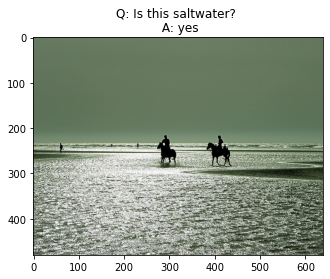

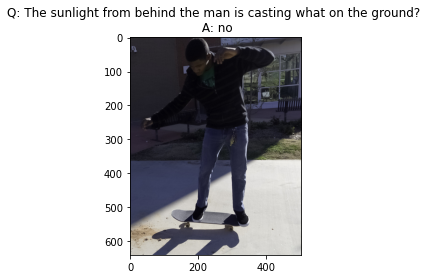

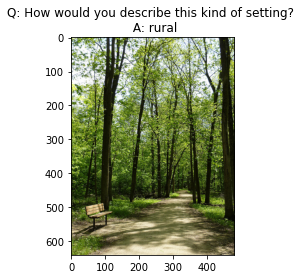

In [97]:
for iC in random.sample(range(0, len(caPathImageVal)), 3):
    DisplayRandomVQAVal(iC)